**Комментарий от студента Титова Д.А.**

В блокноте исследуется процесс предобработки, обучения и предсказания модели нейросети-трансформера для детекции объектов на примере датасета в строительных условиях для определения наличия касок на головах рабочих.

В блокноте применяется FineTuning (дотренировка), т.е. обучение готовой модели с готовыми весами с переопределением последнего на ином датасете. В блокноте применяется модель нейронной сети DETR

In [1]:
!pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate

In [2]:
from datasets import load_dataset

dataset = load_dataset("anindya64/hardhat")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 5297
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 1766
    })
})

In [3]:
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'image_id': 1,
 'width': 500,
 'height': 375,
 'objects': {'id': [1, 1],
  'area': [3068.0, 690.0],
  'bbox': [[178.0, 84.0, 52.0, 59.0], [111.0, 144.0, 23.0, 30.0]],
  'category': ['helmet', 'helmet']}}

In [4]:
# First, extract out the train and test set

train_dataset = dataset["train"]
test_dataset = dataset["test"]

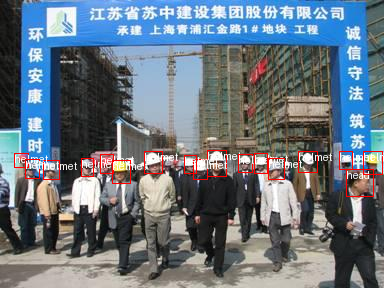

In [5]:
import numpy as np
from PIL import Image, ImageDraw


def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image


draw_image_from_idx(dataset=train_dataset, idx=10)

In [6]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot images

plot_images(train_dataset, range(9))

Output hidden; open in https://colab.research.google.com to view.

In [7]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [8]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [9]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [10]:
# transforming a batch


def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [11]:
# Apply transformations for both train and test dataset

train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)

In [12]:
train_dataset_transformed[0]

{'pixel_values': tensor([[[-0.0287, -0.0287, -0.0287,  ..., -0.1999, -0.3541, -0.4568],
          [-0.0287, -0.0287, -0.0287,  ..., -0.1999, -0.3712, -0.4739],
          [-0.0287, -0.0287, -0.0458,  ..., -0.2171, -0.3883, -0.4911],
          ...,
          [-0.3712, -0.4397, -0.5596,  ..., -0.6109, -0.6794, -0.7137],
          [-0.3712, -0.4568, -0.5767,  ..., -0.6281, -0.6965, -0.7479],
          [-0.3712, -0.4568, -0.5767,  ..., -0.6452, -0.7137, -0.7650]],
 
         [[ 0.0476,  0.0476,  0.0476,  ...,  0.2227,  0.0476, -0.0574],
          [ 0.0476,  0.0476,  0.0476,  ...,  0.2052,  0.0301, -0.0749],
          [ 0.0476,  0.0476,  0.0301,  ...,  0.1877,  0.0126, -0.1099],
          ...,
          [ 0.0651, -0.0399, -0.1800,  ..., -0.3200, -0.3725, -0.4076],
          [ 0.0651, -0.0399, -0.1975,  ..., -0.3375, -0.4076, -0.4426],
          [ 0.0651, -0.0399, -0.1975,  ..., -0.3550, -0.4251, -0.4776]],
 
         [[ 0.3393,  0.3393,  0.3393,  ...,  0.8448,  0.6879,  0.5834],
          [ 

In [13]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [14]:
from transformers import AutoModelForObjectDetection

id2label = {0: "head", 1: "helmet", 2: "person"}
label2id = {v: k for k, v in id2label.items()}


model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

# Define the training arguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50-hardhat-finetuned",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    max_steps=1000,
    fp16=True,
    save_steps=10,
    logging_steps=30,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

# Define the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
)

trainer.train()

/tmp/ipython-input-17-3720040085.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: blackwolfman (blackwolfman-itmo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Не хватает ОЗУ, блокнот прекращает работу

In [ ]:
del model
torch.cuda.synchronize()

In [ ]:
import requests
from transformers import pipeline

# download a sample image

url = "https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/test-helmet-object-detection.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# make the object detection pipeline

obj_detector = pipeline(
    "object-detection", model="anindya64/detr-resnet-50-dc5-hardhat-finetuned"
)
results = obj_detector(train_dataset[0]["image"])

print(results)

In [ ]:
def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

In [ ]:
results = obj_detector(image)
plot_results(image, results)